# Unit09｜分群入門：製程操作模式 (Operating Modes)

本 Notebook 會示範：K-Means / Hierarchical / DBSCAN，並把結果交付成「模式字典」與「模式地圖」。

對應講義：`Part_3/Unit09_Clustering_Operating_Modes.md`


In [21]:
# ===== Shared environment (repo-root + outputs/) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
OUTPUT_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(OUTPUT_DIR)
os.makedirs('Unit09_Results', exist_ok=True)
print('REPO_ROOT:', REPO_ROOT)
print('Working dir:', os.getcwd())


REPO_ROOT: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials
Working dir: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_3


In [22]:
# 匯入套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# 抑制 KMeans 在 Windows 上的 memory leak 警告
os.environ['OMP_NUM_THREADS'] = '5'
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.cluster._kmeans')

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.unicode_minus'] = False

RNG = np.random.default_rng(42)
print('Imports OK')

Imports OK


## 1. 建立示範用製程資料（多種運轉模式 + 少量異常點）

- 4 個模式代表不同操作窗
- 加少量 outliers 當異常候選
- `true_mode` 只用於教學驗證


In [23]:
features = ['T_reactor','P_reactor','F_feed','C_coolant','Reflux_ratio','Energy_kW']

means = np.array([
    [180, 10.0, 100, 25, 1.8,  800],
    [190, 10.5, 105, 26, 2.1,  860],
    [175,  9.6,  95, 24, 1.6,  760],
    [185, 10.2, 110, 27, 1.9,  900],
], dtype=float)

base_cov = np.array([
    [9.0,  0.8,  4.0,  0.5,  0.2,  8.0],
    [0.8,  0.2,  0.6,  0.1,  0.05, 1.2],
    [4.0,  0.6, 25.0,  0.4,  0.15, 6.0],
    [0.5,  0.1,  0.4,  0.6,  0.03, 0.8],
    [0.2,  0.05, 0.15, 0.03, 0.04, 0.6],
    [8.0,  1.2,  6.0,  0.8,  0.6, 20.0],
], dtype=float)

n_per_mode = [300, 250, 250, 250]
X_list = []
mode_list = []
for m, n in enumerate(n_per_mode):
    X_m = RNG.multivariate_normal(mean=means[m], cov=base_cov, size=n)
    X_list.append(X_m)
    mode_list.extend([m] * n)

X = np.vstack(X_list)
true_mode = np.array(mode_list)

outliers = np.column_stack([
    RNG.uniform(160, 210, size=40),
    RNG.uniform(8.5,  12.0, size=40),
    RNG.uniform(80,  130, size=40),
    RNG.uniform(20,   35, size=40),
    RNG.uniform(1.2,  2.6, size=40),
    RNG.uniform(650,  980, size=40),
])

X = np.vstack([X, outliers])
true_mode = np.concatenate([true_mode, [-1] * len(outliers)])

df = pd.DataFrame(X, columns=features)
df['true_mode'] = true_mode
print('data shape:', df.shape)
display(df.head())


data shape: (1090, 7)


,T_reactor,P_reactor,F_feed,C_coolant,Reflux_ratio,Energy_kW,true_mode
0,176.645189,10.312401,101.821295,24.055473,1.643517,796.851961,0
1,179.383554,9.675520,100.386058,25.611235,1.823824,798.670307,0
2,180.362426,10.081148,96.522810,25.738564,1.769873,803.326780,0
3,178.619370,9.437120,96.537740,25.397806,1.619671,796.706760,0
4,179.359156,9.852730,102.816347,24.757840,1.865115,801.020439,0


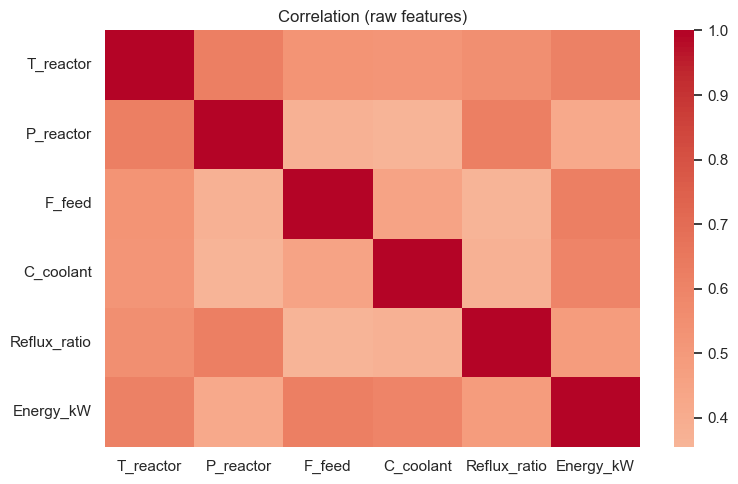

Saved: Unit09_Results/01_corr_heatmap.png


In [24]:
# EDA: correlation
plt.figure(figsize=(8, 5))
sns.heatmap(df[features].corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Correlation (raw features)')
plt.tight_layout()
plt.savefig('./Unit09_Results/01_corr_heatmap.png', dpi=150)
plt.show()
print('Saved: Unit09_Results/01_corr_heatmap.png')


## 2. Scaling：StandardScaler vs RobustScaler

In [25]:
X_raw = df[features].values

sc_std = StandardScaler()
X_std = sc_std.fit_transform(X_raw)

sc_rob = RobustScaler()
X_rob = sc_rob.fit_transform(X_raw)

print('Std scaled mean (approx):', X_std.mean(axis=0).round(3))
print('Robust scaled median (approx):', np.median(X_rob, axis=0).round(3))


Std scaled mean (approx): [ 0. -0. -0.  0.  0. -0.]
Robust scaled median (approx): [ 0.  0.  0. -0.  0.  0.]


## 3. K-Means：選 k（Elbow + Silhouette）

c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39

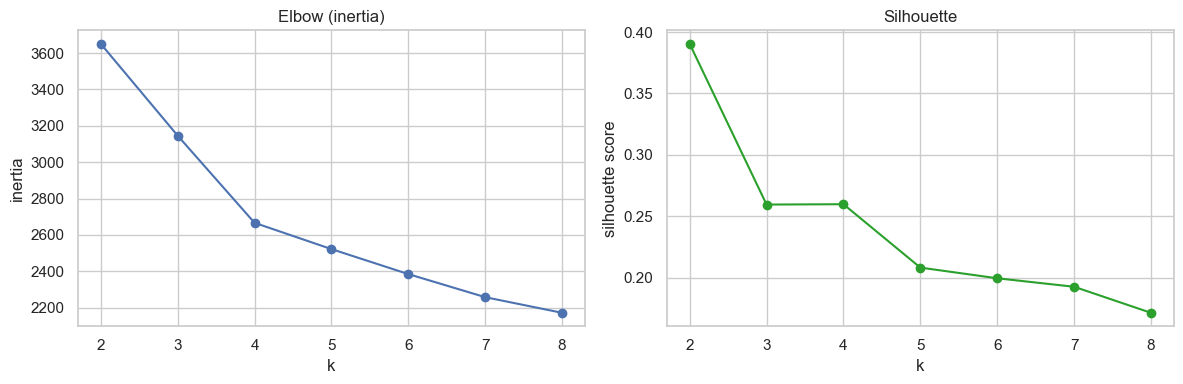

Saved: Unit09_Results/02_k_selection.png
Best k by silhouette: 2


In [26]:
ks = list(range(2, 9))
inertias = []
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_std)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_std, labels))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(ks, inertias, marker='o')
ax[0].set_title('Elbow (inertia)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')

ax[1].plot(ks, sil_scores, marker='o', color='tab:green')
ax[1].set_title('Silhouette')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')

plt.tight_layout()
plt.savefig('./Unit09_Results/02_k_selection.png', dpi=150)
plt.show()
print('Saved: Unit09_Results/02_k_selection.png')

best_k = ks[int(np.argmax(sil_scores))]
print('Best k by silhouette:', best_k)


In [27]:
k = best_k
km = KMeans(n_clusters=k, random_state=42, n_init='auto')
df['cluster_kmeans'] = km.fit_predict(X_std)

profile = df.groupby('cluster_kmeans')[features].agg(['mean', 'std'])
profile.to_csv('./Unit09_Results/mode_profile_table.csv')
print('Saved: Unit09_Results/mode_profile_table.csv')
display(profile)


Saved: Unit09_Results/mode_profile_table.csv


c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


T_reactor            P_reactor                F_feed  \
                      mean       std       mean       std        mean   
cluster_kmeans                                                          
0               186.971174  4.973118  10.340896  0.475843  107.267635   
1               177.164115  4.011575   9.714883  0.445892   97.003712   

                          C_coolant           Reflux_ratio            \
                     std       mean       std         mean       std   
cluster_kmeans                                                         
0               6.008696  26.381062  1.411694     1.982219  0.239500   
1               5.584108  24.379075  0.960098     1.662537  0.211264   

                 Energy_kW             
                      mean        std  
cluster_kmeans                         
0               867.735870  37.684935  
1               779.094306  24.938744

## 3.1 模式穩定性（Stability）：不同 seed / 不同時間切片會不會改變？

這一段就是把「學術上的分群」變成「工程上可用」：

1. **seed stability**：不同初始化是否得到類似分群？
2. **time slice stability**：把資料切成早期/晚期（模擬不同月份/不同設備狀態），分群是否一致？
3. **centroid drift**：群中心是否隨時間漂移？（原料切換/設備老化）


c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39

k = 2
Seeds: [0, 1, 2, 3, 4, 5, 6]
ARI mean ± std: 0.998 ± 0.002
ARI (min/max): 0.996 / 1.0


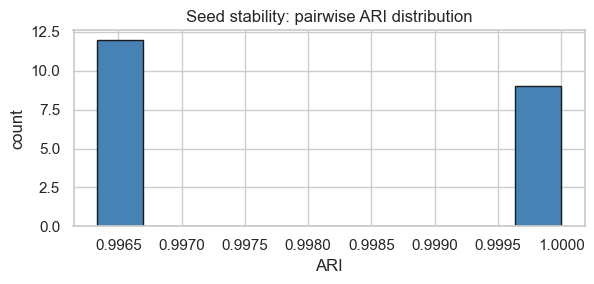

Saved: Unit09_Results/06_seed_stability_ari.png


In [28]:
# 3.1.1 seed stability：用 ARI 量化分群結果是否一致
from sklearn.metrics import adjusted_rand_score

k_fixed = int(best_k)
labels_list = []
seeds = [0, 1, 2, 3, 4, 5, 6]

for sd in seeds:
    km_tmp = KMeans(n_clusters=k_fixed, random_state=sd, n_init='auto')
    labels_list.append(km_tmp.fit_predict(X_std))

# pairwise ARI
aris = []
for i in range(len(labels_list)):
    for j in range(i+1, len(labels_list)):
        aris.append(adjusted_rand_score(labels_list[i], labels_list[j]))

print('k =', k_fixed)
print('Seeds:', seeds)
print('ARI mean ± std:', round(float(np.mean(aris)), 3), '±', round(float(np.std(aris)), 3))
print('ARI (min/max):', round(float(np.min(aris)), 3), '/', round(float(np.max(aris)), 3))

plt.figure(figsize=(6, 3))
plt.hist(aris, bins=10, color='steelblue', edgecolor='k')
plt.title('Seed stability: pairwise ARI distribution')
plt.xlabel('ARI')
plt.ylabel('count')
plt.tight_layout()
plt.savefig('./Unit09_Results/06_seed_stability_ari.png', dpi=150)
plt.show()
print('Saved: Unit09_Results/06_seed_stability_ari.png')


Centroid drift distances (per early cluster): [2.389 1.99 ]
Mean drift: 2.189


c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


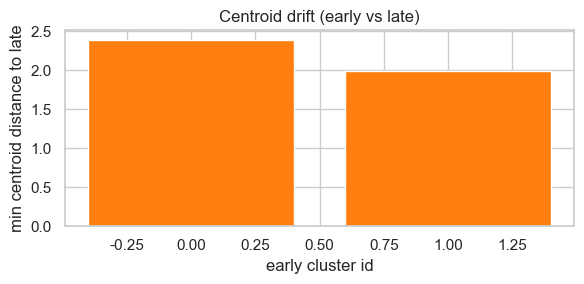

Saved: Unit09_Results/07_centroid_drift.png


In [29]:
# 3.1.2 time slice stability：早期/晚期分群對照 + centroid drift

# 模擬時間（前 60% = early，後 40% = late）
# 也模擬一個『慢性漂移』：晚期的 Energy_kW 偏高（例如 fouling / 操作策略改變）
df_ts = df.copy()
df_ts['t_index'] = np.arange(len(df_ts))

split = int(len(df_ts) * 0.6)

X_early = X_raw.copy()
X_late = X_raw.copy()

# 注入 drift：晚期能耗 + 50（原始尺度）
X_late[split:, features.index('Energy_kW')] += 50.0

X_early_std = sc_std.fit_transform(X_early)  # early 作為基準 fit scaler（工程上常見做法）
X_late_std = sc_std.transform(X_late)

km_early = KMeans(n_clusters=k_fixed, random_state=42, n_init='auto').fit(X_early_std[:split])
km_late = KMeans(n_clusters=k_fixed, random_state=42, n_init='auto').fit(X_late_std[split:])

cent_early = km_early.cluster_centers_
cent_late = km_late.cluster_centers_

# centroid drift（在標準化空間的距離）
# 注意：群 label 可能對不上，這裡用最小匹配距離做簡化示範
from scipy.spatial.distance import cdist
D = cdist(cent_early, cent_late)
match_dist = D.min(axis=1)

print('Centroid drift distances (per early cluster):', np.round(match_dist, 3))
print('Mean drift:', round(float(match_dist.mean()), 3))

plt.figure(figsize=(6, 3))
plt.bar(np.arange(k_fixed), match_dist, color='tab:orange')
plt.xlabel('early cluster id')
plt.ylabel('min centroid distance to late')
plt.title('Centroid drift (early vs late)')
plt.tight_layout()
plt.savefig('./Unit09_Results/07_centroid_drift.png', dpi=150)
plt.show()
print('Saved: Unit09_Results/07_centroid_drift.png')


**工程解讀提示**：
- seed stability 很差：代表你資料沒有清楚群結構、或需要先做降維/挑特徵
- centroid drift 明顯：代表模式本身在變（設備/原料/控制策略），你需要把「漂移」納入監控與重訓策略（Unit11）


## 4. 模式地圖：PCA 2D

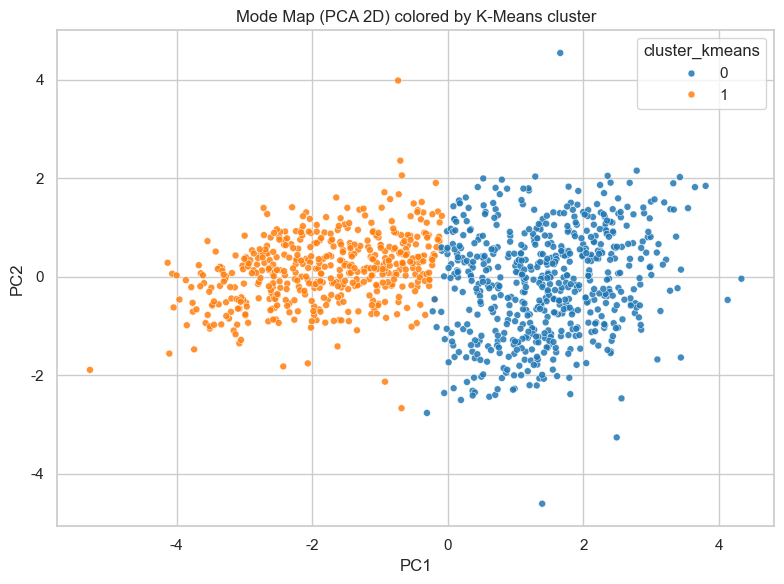

Saved: Unit09_Results/03_mode_map_pca.png
Explained variance ratio: [0.586 0.146]


In [30]:
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_std)

df['PC1'] = Z[:, 0]
df['PC2'] = Z[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_kmeans', palette='tab10', s=25, alpha=0.85)
plt.title('Mode Map (PCA 2D) colored by K-Means cluster')
plt.tight_layout()
plt.savefig('./Unit09_Results/03_mode_map_pca.png', dpi=150)
plt.show()
print('Saved: Unit09_Results/03_mode_map_pca.png')

print('Explained variance ratio:', pca.explained_variance_ratio_.round(3))


## 5. Hierarchical clustering（dendrogram）

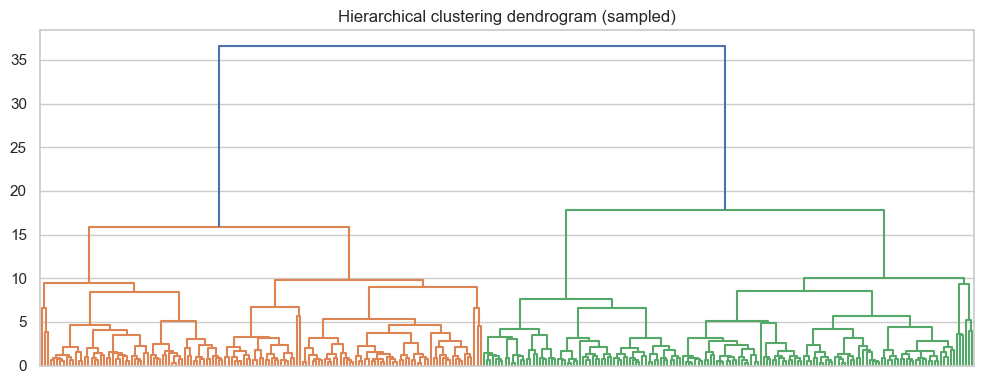

Saved: Unit09_Results/04_dendrogram.png


In [31]:
from scipy.cluster.hierarchy import linkage, dendrogram

idx = RNG.choice(len(df), size=300, replace=False)
X_sub = X_std[idx]

Z_link = linkage(X_sub, method='ward')

plt.figure(figsize=(10, 4))
dendrogram(Z_link, no_labels=True)
plt.title('Hierarchical clustering dendrogram (sampled)')
plt.tight_layout()
plt.savefig('./Unit09_Results/04_dendrogram.png', dpi=150)
plt.show()
print('Saved: Unit09_Results/04_dendrogram.png')


## 6. DBSCAN：把稀疏點當異常候選（先 PCA 再 DBSCAN）

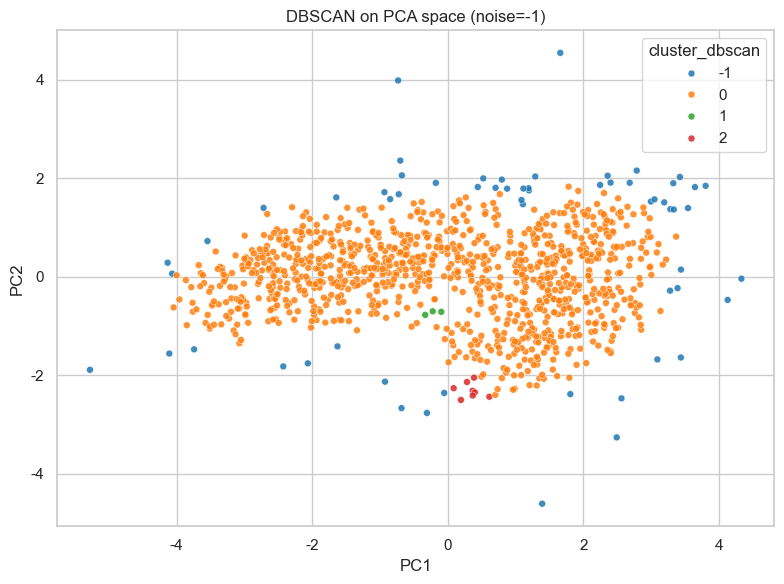

Saved: Unit09_Results/05_dbscan_pca.png
DBSCAN label counts:
-1      60
 0    1019
 1       3
 2       8
Name: count, dtype: int64


In [32]:
db = DBSCAN(eps=0.35, min_samples=10)
labels_db = db.fit_predict(Z)
df['cluster_dbscan'] = labels_db

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_dbscan', palette='tab10', s=25, alpha=0.85)
plt.title('DBSCAN on PCA space (noise=-1)')
plt.tight_layout()
plt.savefig('./Unit09_Results/05_dbscan_pca.png', dpi=150)
plt.show()
print('Saved: Unit09_Results/05_dbscan_pca.png')

print('DBSCAN label counts:')
print(pd.Series(labels_db).value_counts().sort_index())


## 練習題

1. 把 `RobustScaler` 換進 K-Means，觀察群中心與 silhouette 是否變化。
2. 把 `eps/min_samples` 調整到能穩定抓出你想要的 `noise` 比例。
3. 嘗試用工程語言命名每一群（高溫高壓、能耗高、回流比高…）。
